# LightGCN

## Import libraries

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from typing import Dict

from torch import nn, optim, Tensor, torch
from torch_geometric.utils.num_nodes import maybe_num_nodes

In [2]:
from data_loaders.data_loader_lightgcn import UserUserDatasetLightGCN
from light_gcn.light_gcn import LightGCN, bpr_loss, get_user_positive_items, RecallPrecision_ATk, NDCGatK_r, get_metrics, evaluation

In [3]:
torch.__version__

'2.1.1+cu118'

In [4]:
torch.device('cuda')

device(type='cuda')

In [5]:
print(torch.cuda.is_available()) 

True


## Import data

In [6]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

datasets_dict = {
    "postings": postings,
    "votes": votes
}

## Create a UserUserDataset object for LightGCN model

In [7]:
uu_dataset_lightgcn = UserUserDatasetLightGCN(datasets_dict = datasets_dict, verbose = True)

Size of user-article interaction dataframe:  (895196, 6)
Number of unique users:  33703
Number of unique articles:  4351
Number of edges:  895196


In [8]:
train_edge_index, val_edge_index, test_edge_index = uu_dataset_lightgcn.get_train_test_val_split(val_split_ratio = 0.2, test_split_ratio = 0.5, random_state = 1, sparse = False)

Train edge index shape:  torch.Size([2, 716156])
Val edge index shape:  torch.Size([2, 89520])
Test edge index shape:  torch.Size([2, 89520])


In [9]:
source, target, negative_target = uu_dataset_lightgcn.get_negative_samples(train_edge_index)

In [10]:
user_indices, pos_item_indices, neg_item_indices = uu_dataset_lightgcn.get_random_mini_batches(512)

# LightGCN: Run training loop

In [11]:
num_users, num_articles = uu_dataset_lightgcn.num_users, uu_dataset_lightgcn.num_articles
model = LightGCN(num_users, num_articles)

In [12]:
ITERATIONS = 2000
BATCH_SIZE = 64 * 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [13]:
# setup
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = uu_dataset_lightgcn.edge_index.to(device)

train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = uu_dataset_lightgcn.train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = uu_dataset_lightgcn.val_sparse_edge_index.to(device)

Using device cuda.


In [14]:
# training loop
train_losses = []
val_losses = []
recall_list = []
precision_list = []
ndcg_list = []
hits_list = []

for iter in tqdm(range(ITERATIONS)):

    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = uu_dataset_lightgcn.get_random_mini_batches(BATCH_SIZE)

    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg, hits = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}, val_hits@{K}: {round(hits, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        recall_list.append(recall)
        precision_list.append(precision)
        ndcg_list.append(ndcg)
        hits_list.append(hits)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

33703


  0%|          | 3/2000 [00:53<7:38:24, 13.77s/it] 

[Iteration 0/2000] train_loss: -0.56726, val_loss: -0.52362, val_recall@20: 0.00467, val_precision@20: 0.00116, val_ndcg@20: 0.00256, val_hits@20: 0.0113


 10%|▉         | 199/2000 [01:12<02:54, 10.33it/s]

33703


 10%|█         | 203/2000 [02:04<2:45:02,  5.51s/it]

[Iteration 200/2000] train_loss: -3.86438, val_loss: -0.53937, val_recall@20: 0.05004, val_precision@20: 0.01201, val_ndcg@20: 0.02682, val_hits@20: 0.11886


 20%|█▉        | 399/2000 [02:24<02:37, 10.15it/s]  

33703


 20%|██        | 403/2000 [03:17<2:32:57,  5.75s/it]

[Iteration 400/2000] train_loss: -16.56464, val_loss: -0.88574, val_recall@20: 0.05341, val_precision@20: 0.01289, val_ndcg@20: 0.02774, val_hits@20: 0.12263


 30%|██▉       | 599/2000 [03:36<02:17, 10.16it/s]  

33703


 30%|███       | 603/2000 [04:29<2:10:17,  5.60s/it]

[Iteration 600/2000] train_loss: -35.31868, val_loss: -1.56129, val_recall@20: 0.05472, val_precision@20: 0.01313, val_ndcg@20: 0.02808, val_hits@20: 0.12388


 40%|████      | 800/2000 [04:49<01:57, 10.24it/s]  

33703


 40%|████      | 803/2000 [05:43<2:15:09,  6.77s/it]

[Iteration 800/2000] train_loss: -58.78853, val_loss: -2.41599, val_recall@20: 0.05682, val_precision@20: 0.01367, val_ndcg@20: 0.03039, val_hits@20: 0.12953


 50%|█████     | 1000/2000 [06:03<01:40, 10.00it/s] 

33703


 50%|█████     | 1003/2000 [06:57<1:46:27,  6.41s/it]

[Iteration 1000/2000] train_loss: -84.72172, val_loss: -3.39265, val_recall@20: 0.05912, val_precision@20: 0.01392, val_ndcg@20: 0.03204, val_hits@20: 0.13524


 60%|██████    | 1200/2000 [07:17<01:36,  8.32it/s]  

33703


 60%|██████    | 1203/2000 [08:11<1:54:59,  8.66s/it]

[Iteration 1200/2000] train_loss: -113.48421, val_loss: -4.4501, val_recall@20: 0.05994, val_precision@20: 0.01413, val_ndcg@20: 0.0329, val_hits@20: 0.14042


 70%|███████   | 1400/2000 [08:31<00:57, 10.38it/s]  

33703


 70%|███████   | 1403/2000 [09:23<1:02:04,  6.24s/it]

[Iteration 1400/2000] train_loss: -143.24269, val_loss: -5.402, val_recall@20: 0.06207, val_precision@20: 0.01462, val_ndcg@20: 0.03394, val_hits@20: 0.14398


 80%|████████  | 1600/2000 [09:44<00:39, 10.19it/s]  

33703


 80%|████████  | 1603/2000 [10:37<42:03,  6.36s/it]  

[Iteration 1600/2000] train_loss: -175.15379, val_loss: -6.50373, val_recall@20: 0.06349, val_precision@20: 0.01485, val_ndcg@20: 0.03446, val_hits@20: 0.14377


 90%|█████████ | 1800/2000 [10:57<00:19, 10.03it/s]

33703


 90%|█████████ | 1803/2000 [11:52<21:29,  6.55s/it]

[Iteration 1800/2000] train_loss: -206.65463, val_loss: -7.67016, val_recall@20: 0.0659, val_precision@20: 0.01541, val_ndcg@20: 0.0354, val_hits@20: 0.1479


100%|██████████| 2000/2000 [12:12<00:00,  2.73it/s]


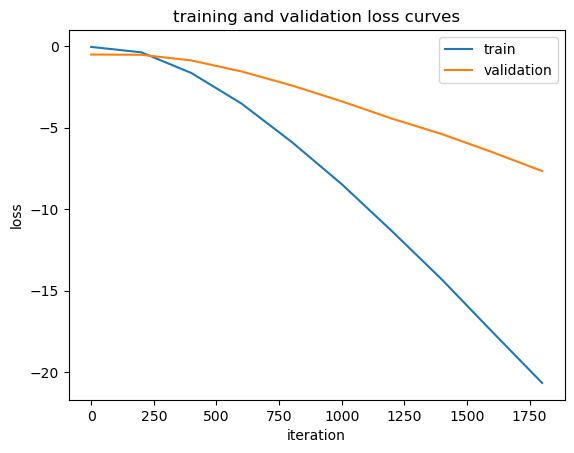

In [15]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, np.array(train_losses)/10, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

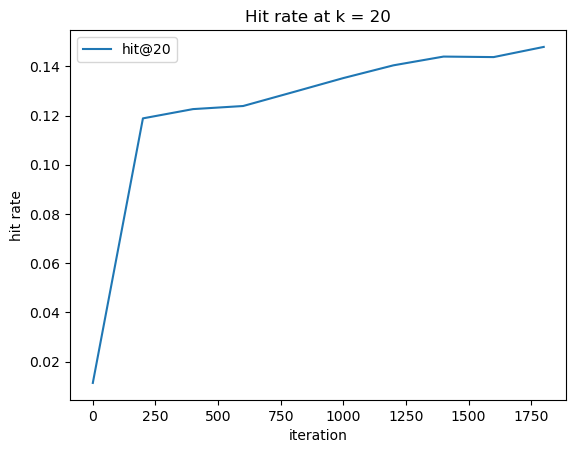

In [19]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
# plt.plot(iters, np.array(train_losses)/10, label='train')
plt.title('Hit rate at k = 20')
plt.plot(iters, hits_list, label='hit@20')
plt.xlabel('iteration')
plt.ylabel('hit rate')

plt.legend()
plt.show()

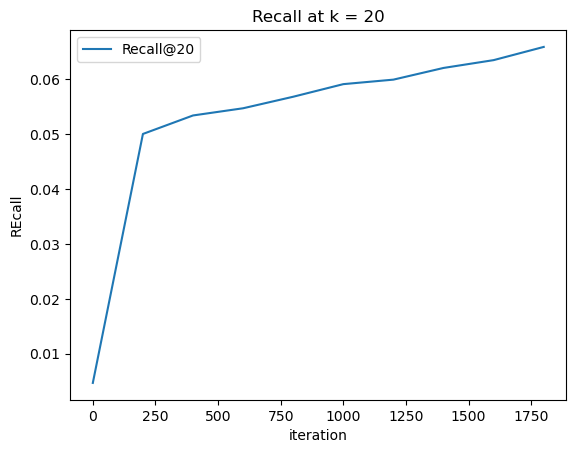

In [20]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
# plt.plot(iters, np.array(train_losses)/10, label='train')
plt.title('Recall at k = 20')
plt.plot(iters, recall_list, label='Recall@20')
plt.xlabel('iteration')
plt.ylabel('REcall')

plt.legend()
plt.show()

# GraphSage

## Import libraries

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator 
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import matplotlib.pyplot as plt 
import numpy as np 

import subprocess as sp
import os
from tqdm import tqdm


In [10]:
from graphsage.graphsage import GNNStack, LinkPredictor, train, test
from data_loaders.data_loader_graphsage import UserUserDatasetGraphSAGE

## Import data

In [11]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

datasets_dict = {
    "postings": postings,
    "votes": votes
}

## Create UserUser dataset for GraphSAGE model

In [12]:
uu_dataset_graphsage = UserUserDatasetGraphSAGE(datasets_dict = datasets_dict, verbose = True)

User-article interaction dataframe created with 895196 rows
User-article interaction dataframe subsampled to 223799 rows
Graph created with 28988 nodes and 447598 edges


In [13]:
split_edge = uu_dataset_graphsage.create_train_test_split()

24915 4073
Train edges:  torch.Size([2, 179039])
Valid positive edges:  torch.Size([2, 22380])
Valid negative edges:  torch.Size([2, 22380])
Test positive edges:  torch.Size([2, 22380])
Test negative edges:  torch.Size([2, 22380])


/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/data_loaders/data_loader_graphsage.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)],


# Run training loop

In [14]:
evaluator = Evaluator(name='ogbl-ddi')
print(evaluator.expected_input_format)

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


In [15]:
# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 20
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 5e-5
node_emb_dim = 256
batch_size = 512

In [16]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [36]:
# https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN#scrollTo=gG6mGvs9Uqnt

pos_train_edge = split_edge['train']['edge'].to(device)

emb = torch.nn.Embedding(uu_dataset_graphsage.graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

evaluator = Evaluator(name='ogbl-ddi')

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = uu_dataset_graphsage.graph.edge_index.to(device)

print("Before training. Available GPU memory: ", get_gpu_memory())

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    loss_val_pos_list.append(result["loss_val_pos"])
    loss_val_neg_list.append(result["loss_val_neg"])
    loss_test_pos_list.append(result["loss_test_pos"])
    loss_test_neg_list.append(result["loss_test_neg"])

Before training. Available GPU memory:  [438]


  0%|          | 0/20 [00:00<?, ?it/s]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T


Train loss:  1.3226100895946422


  5%|▌         | 1/20 [01:26<27:27, 86.69s/it]

Loss val pos:  tensor(0.6278)
Loss val neg:  tensor(0.5903)
Loss test pos:  tensor(0.6275)
Loss test neg:  tensor(0.5913)
Train loss:  1.1072325635291373


 10%|█         | 2/20 [02:53<26:01, 86.73s/it]

Loss val pos:  tensor(0.3797)
Loss val neg:  tensor(0.7692)
Loss test pos:  tensor(0.3798)
Loss test neg:  tensor(0.7713)
Train loss:  1.0220827718529266


 15%|█▌        | 3/20 [04:29<25:43, 90.76s/it]

Loss val pos:  tensor(0.2777)
Loss val neg:  tensor(0.8254)
Loss test pos:  tensor(0.2778)
Loss test neg:  tensor(0.8269)
Train loss:  0.977723990865837


 20%|██        | 4/20 [06:34<27:50, 104.38s/it]

Loss val pos:  tensor(0.2353)
Loss val neg:  tensor(0.8136)
Loss test pos:  tensor(0.2354)
Loss test neg:  tensor(0.8174)
Train loss:  0.9246571674000742


 25%|██▌       | 5/20 [08:39<27:57, 111.86s/it]

Loss val pos:  tensor(0.1925)
Loss val neg:  tensor(0.9192)
Loss test pos:  tensor(0.1928)
Loss test neg:  tensor(0.9229)
Train loss:  0.9328337405269542


 30%|███       | 6/20 [10:44<27:09, 116.38s/it]

Loss val pos:  tensor(0.1743)
Loss val neg:  tensor(0.9403)
Loss test pos:  tensor(0.1747)
Loss test neg:  tensor(0.9420)
Train loss:  0.9073855000301603


 35%|███▌      | 7/20 [12:49<25:50, 119.30s/it]

Loss val pos:  tensor(0.1661)
Loss val neg:  tensor(0.8727)
Loss test pos:  tensor(0.1662)
Loss test neg:  tensor(0.8773)
Train loss:  0.8995100966102904


 40%|████      | 8/20 [14:55<24:14, 121.21s/it]

Loss val pos:  tensor(0.1435)
Loss val neg:  tensor(0.9621)
Loss test pos:  tensor(0.1434)
Loss test neg:  tensor(0.9669)
Train loss:  0.8848623626405238


 45%|████▌     | 9/20 [17:00<22:27, 122.49s/it]

Loss val pos:  tensor(0.1310)
Loss val neg:  tensor(0.9170)
Loss test pos:  tensor(0.1309)
Loss test neg:  tensor(0.9224)
Train loss:  0.872760674713367


 50%|█████     | 10/20 [19:05<20:33, 123.35s/it]

Loss val pos:  tensor(0.1212)
Loss val neg:  tensor(0.9691)
Loss test pos:  tensor(0.1214)
Loss test neg:  tensor(0.9751)
Train loss:  0.8403917554530382


 55%|█████▌    | 11/20 [21:11<18:35, 123.94s/it]

Loss val pos:  tensor(0.1432)
Loss val neg:  tensor(0.8610)
Loss test pos:  tensor(0.1432)
Loss test neg:  tensor(0.8643)
Train loss:  0.8089626485207042


 60%|██████    | 12/20 [23:16<16:34, 124.36s/it]

Loss val pos:  tensor(0.1177)
Loss val neg:  tensor(0.9151)
Loss test pos:  tensor(0.1173)
Loss test neg:  tensor(0.9190)
Train loss:  0.8623008449546626


 65%|██████▌   | 13/20 [25:21<14:32, 124.65s/it]

Loss val pos:  tensor(0.1181)
Loss val neg:  tensor(0.9569)
Loss test pos:  tensor(0.1174)
Loss test neg:  tensor(0.9599)
Train loss:  0.8331772649455684


 70%|███████   | 14/20 [27:26<12:29, 124.85s/it]

Loss val pos:  tensor(0.1264)
Loss val neg:  tensor(0.8613)
Loss test pos:  tensor(0.1256)
Loss test neg:  tensor(0.8671)
Train loss:  0.8052829237397438


 75%|███████▌  | 15/20 [29:32<10:25, 125.06s/it]

Loss val pos:  tensor(0.1021)
Loss val neg:  tensor(0.9865)
Loss test pos:  tensor(0.1014)
Loss test neg:  tensor(0.9939)
Train loss:  0.7883182040282658


 80%|████████  | 16/20 [31:39<08:22, 125.56s/it]

Loss val pos:  tensor(0.0987)
Loss val neg:  tensor(1.0126)
Loss test pos:  tensor(0.0980)
Loss test neg:  tensor(1.0196)
Train loss:  0.7832496854404655


 85%|████████▌ | 17/20 [33:48<06:20, 126.80s/it]

Loss val pos:  tensor(0.1358)
Loss val neg:  tensor(0.8544)
Loss test pos:  tensor(0.1352)
Loss test neg:  tensor(0.8602)
Train loss:  0.8014675255960826


 90%|█████████ | 18/20 [35:58<04:15, 127.66s/it]

Loss val pos:  tensor(0.1451)
Loss val neg:  tensor(0.7987)
Loss test pos:  tensor(0.1445)
Loss test neg:  tensor(0.8055)
Train loss:  0.7962405433141097


 95%|█████████▌| 19/20 [38:08<02:08, 128.26s/it]

Loss val pos:  tensor(0.1132)
Loss val neg:  tensor(0.9364)
Loss test pos:  tensor(0.1125)
Loss test neg:  tensor(0.9426)
Train loss:  0.7929731693284573


100%|██████████| 20/20 [40:18<00:00, 120.90s/it]

Loss val pos:  tensor(0.1163)
Loss val neg:  tensor(0.9280)
Loss test pos:  tensor(0.1157)
Loss test neg:  tensor(0.9324)


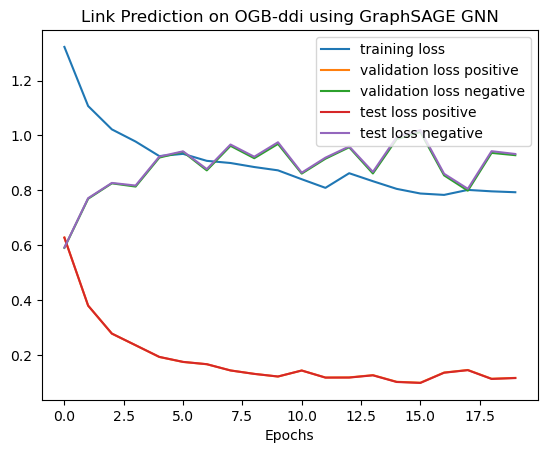

In [42]:
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(np.array(train_loss),label="training loss")
plt.plot(loss_val_pos_list,label="validation loss positive")
plt.plot(loss_val_neg_list,label="validation loss negative")
plt.plot(loss_test_pos_list,label="test loss positive")
plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score

def calculate_roc_auc(models, split_edge, batch_size):
    
    device = 'cuda' if torch.cuda.is_available() else "cpu"

    pos_valid_edge = split_edge['valid']['edge'].T.to(device)
    neg_valid_edge = split_edge['valid']['edge_neg'].T.to(device)
    
    pos_test_edge = split_edge['test']['edge'].T.to(device)
    neg_test_edge = split_edge['test']['edge_neg'].T.to(device)

    model = models["model"]
    predictor = models["link_predictor"]
    node_emb = models["emb"].weight

    model.eval()
    predictor.eval()
    # node_emb = model(emb, edge_index)

    with torch.no_grad():

        valid_loss = []
        valid_pos_preds = []
        valid_neg_preds = []
        for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
            edge_pos = pos_valid_edge[perm].t()
            edge_neg = neg_valid_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            valid_pos_preds += [pos_preds]
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            valid_neg_preds += [neg_preds]
            loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
            valid_loss.append(loss.item())
        
        true_labels_val = torch.cat([torch.ones(pos_valid_edge.shape[0]), torch.zeros(neg_valid_edge.shape[0])]).detach().numpy()
        pred_labels_val = torch.cat([torch.cat(valid_pos_preds), torch.cat(valid_neg_preds)]).detach().numpy()
        
        roc_auc = roc_auc_score(true_labels_val, pred_labels_val)
        print("Validation ROC AUC: ", roc_auc)
        print("Validation loss: ", sum(valid_loss) / len(valid_loss))

        test_loss = []
        test_pos_preds = []
        test_neg_preds = []
        for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
            edge_pos = pos_test_edge[perm].t()
            edge_neg = neg_test_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            test_pos_preds += [pos_preds]
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            test_neg_preds += [neg_preds]
            loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
            test_loss.append(loss.item())

        true_labels_test = torch.cat([torch.ones(pos_test_edge.shape[0]), torch.zeros(neg_test_edge.shape[0])]).detach().numpy()
        pred_labels_test = torch.cat([torch.cat(test_pos_preds), torch.cat(test_neg_preds)]).detach().numpy()
        roc_auc = roc_auc_score(true_labels_test, pred_labels_test)
        print("Validation ROC AUC: ", roc_auc)
        print("Test loss: ", sum(test_loss) / len(test_loss))


models = {}
models["model"] = model
models["link_predictor"] = link_predictor
models["emb"] = emb
calculate_roc_auc(models, split_edge, batch_size)

Validation ROC AUC:  0.49504272455735454
Validation loss:  2.6144261801684343
Validation ROC AUC:  0.4977116399257112
Test loss:  2.603285453937672


: 

# Create UserUser dataset for GraphSAGE model

In [13]:
from data_loaders.data_loader_graphsage import UserUserDatasetGraphSAGE
from graphsage.graphsage import GNNStack, LinkPredictor, train, test
from ogb.linkproppred import Evaluator
import subprocess as sp 

In [14]:
uu_dataset_graphsage = UserUserDatasetGraphSAGE(datasets_dict = datasets_dict, verbose = True)

User-article interaction dataframe created with 895196 rows
User-article interaction dataframe subsampled to 447598 rows
Graph created with 33557 nodes and 447598 edges


In [15]:
split_edge = uu_dataset_graphsage.create_train_test_split(uu_dataset_graphsage.graph.edge_index.t())

29332 4225


/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/data_loaders/data_loader_graphsage.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)],


Train edges:  torch.Size([2, 358078])
Valid positive edges:  torch.Size([2, 44760])
Valid negative edges:  torch.Size([2, 44760])
Test positive edges:  torch.Size([2, 44760])
Test negative edges:  torch.Size([2, 44760])


# Run training loop

In [16]:
torch.cuda.is_available()

True

In [17]:
# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 50
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 5e-4
node_emb_dim = 256
batch_size = 16*1024

In [18]:
# https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN#scrollTo=gG6mGvs9Uqnt

pos_train_edge = split_edge['train']['edge'].to(device)
num_nodes = len(np.unique(uu_dataset_graphsage.graph.edge_index))
emb = torch.nn.Embedding(num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

In [19]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [20]:
get_gpu_memory()

[1630]

In [21]:


evaluator = Evaluator(name='ogbl-ddi')

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = uu_dataset_graphsage.edge_index.to(device)

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []
hits_20 = []
hits_50 = []
hits_100 = []
roc_auc_val = []
roc_auc_test = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    loss_val_pos_list.append(result["loss_val_pos"])
    loss_val_neg_list.append(result["loss_val_neg"])
    loss_test_pos_list.append(result["loss_test_pos"])
    loss_test_neg_list.append(result["loss_test_neg"])
    hits_20.append(result["Hits@20"])
    hits_50.append(result["Hits@50"])
    hits_100.append(result["Hits@100"])
    roc_auc_val.append(result["roc_auc_val"])
    roc_auc_test.append(result["roc_auc_test"])

  0%|          | 0/50 [00:00<?, ?it/s]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0
100%|██████████| 22/22 [00:08<00:00,  2.74it/s]


Train loss:  1.3494109186259182


  2%|▏         | 1/50 [00:08<06:58,  8.54s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3830)
Loss val neg:  tensor(0.8745)
Loss test pos:  tensor(0.3860)
Loss test neg:  tensor(0.8758)
ROC-AUC val:  0.7603268761465178
ROC-AUC test:  0.7582612749079392


100%|██████████| 22/22 [00:07<00:00,  2.83it/s]


Train loss:  1.12886503609744


  4%|▍         | 2/50 [00:16<06:40,  8.34s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3182)
Loss val neg:  tensor(0.7571)
Loss test pos:  tensor(0.3190)
Loss test neg:  tensor(0.7582)
ROC-AUC val:  0.8386067668714328
ROC-AUC test:  0.8388838792994671


100%|██████████| 22/22 [00:05<00:00,  3.74it/s]


Train loss:  1.0278654152696782


  6%|▌         | 3/50 [00:23<05:49,  7.44s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3233)
Loss val neg:  tensor(0.7071)
Loss test pos:  tensor(0.3241)
Loss test neg:  tensor(0.7062)
ROC-AUC val:  0.8474580270628138
ROC-AUC test:  0.8485403504421556


100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Train loss:  1.0007305416193875


  8%|▊         | 4/50 [00:31<06:01,  7.86s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3141)
Loss val neg:  tensor(0.7037)
Loss test pos:  tensor(0.3144)
Loss test neg:  tensor(0.7019)
ROC-AUC val:  0.8497982565241211
ROC-AUC test:  0.8514581496508835


100%|██████████| 22/22 [00:06<00:00,  3.49it/s]


Train loss:  0.9856618669900027


 10%|█         | 5/50 [00:38<05:37,  7.49s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3290)
Loss val neg:  tensor(0.6703)
Loss test pos:  tensor(0.3294)
Loss test neg:  tensor(0.6686)
ROC-AUC val:  0.8512978635035751
ROC-AUC test:  0.8526445610828


100%|██████████| 22/22 [00:08<00:00,  2.49it/s]


Train loss:  0.9812710583209991


 12%|█▏        | 6/50 [00:47<05:57,  8.13s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3447)
Loss val neg:  tensor(0.6421)
Loss test pos:  tensor(0.3453)
Loss test neg:  tensor(0.6403)
ROC-AUC val:  0.8520440791958861
ROC-AUC test:  0.8534527426485092


100%|██████████| 22/22 [00:09<00:00,  2.22it/s]


Train loss:  0.9730843197215687


 14%|█▍        | 7/50 [00:58<06:22,  8.89s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3316)
Loss val neg:  tensor(0.6577)
Loss test pos:  tensor(0.3322)
Loss test neg:  tensor(0.6552)
ROC-AUC val:  0.8524831770834581
ROC-AUC test:  0.8539997370046664


100%|██████████| 22/22 [00:09<00:00,  2.22it/s]


Train loss:  0.9701411155137148


 16%|█▌        | 8/50 [01:08<06:35,  9.41s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3511)
Loss val neg:  tensor(0.6268)
Loss test pos:  tensor(0.3515)
Loss test neg:  tensor(0.6249)
ROC-AUC val:  0.8530340687020279
ROC-AUC test:  0.8545052430857534


100%|██████████| 22/22 [00:10<00:00,  2.20it/s]


Train loss:  0.9653773009777069


 18%|█▊        | 9/50 [01:19<06:40,  9.78s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3503)
Loss val neg:  tensor(0.6231)
Loss test pos:  tensor(0.3510)
Loss test neg:  tensor(0.6206)
ROC-AUC val:  0.853445177726746
ROC-AUC test:  0.8549459392102932


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9612208090045236


 20%|██        | 10/50 [01:29<06:40, 10.02s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3536)
Loss val neg:  tensor(0.6192)
Loss test pos:  tensor(0.3544)
Loss test neg:  tensor(0.6167)
ROC-AUC val:  0.8536325842383687
ROC-AUC test:  0.8551399615344992


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9600513685833324


 22%|██▏       | 11/50 [01:40<06:37, 10.19s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3458)
Loss val neg:  tensor(0.6294)
Loss test pos:  tensor(0.3463)
Loss test neg:  tensor(0.6271)
ROC-AUC val:  0.8536886033924552
ROC-AUC test:  0.8552942153604848


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9555361785671928


 24%|██▍       | 12/50 [01:51<06:31, 10.31s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3495)
Loss val neg:  tensor(0.6211)
Loss test pos:  tensor(0.3503)
Loss test neg:  tensor(0.6184)
ROC-AUC val:  0.854123375508421
ROC-AUC test:  0.8557388529210701


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9551045894622803


 26%|██▌       | 13/50 [02:01<06:24, 10.39s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3513)
Loss val neg:  tensor(0.6181)
Loss test pos:  tensor(0.3519)
Loss test neg:  tensor(0.6154)
ROC-AUC val:  0.8543512191123985
ROC-AUC test:  0.8560550492808034


100%|██████████| 22/22 [00:09<00:00,  2.44it/s]


Train loss:  0.9551994069056078


 28%|██▊       | 14/50 [02:11<06:03, 10.10s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3601)
Loss val neg:  tensor(0.6028)
Loss test pos:  tensor(0.3605)
Loss test neg:  tensor(0.6005)
ROC-AUC val:  0.8547396767967537
ROC-AUC test:  0.8563341435326607


100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


Train loss:  0.9517302404750477


 30%|███       | 15/50 [02:19<05:33,  9.54s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3823)
Loss val neg:  tensor(0.5728)
Loss test pos:  tensor(0.3826)
Loss test neg:  tensor(0.5706)
ROC-AUC val:  0.8549240642776768
ROC-AUC test:  0.856631923231118


100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


Train loss:  0.9516716762022539


 32%|███▏      | 16/50 [02:27<05:11,  9.15s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3635)
Loss val neg:  tensor(0.5970)
Loss test pos:  tensor(0.3640)
Loss test neg:  tensor(0.5943)
ROC-AUC val:  0.8550519891212074
ROC-AUC test:  0.8567609202211217


100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Train loss:  0.9463833218271082


 34%|███▍      | 17/50 [02:35<04:54,  8.92s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3660)
Loss val neg:  tensor(0.5913)
Loss test pos:  tensor(0.3663)
Loss test neg:  tensor(0.5891)
ROC-AUC val:  0.8554314985253493
ROC-AUC test:  0.8571122695583874


100%|██████████| 22/22 [00:07<00:00,  2.81it/s]


Train loss:  0.9449071911248293
Loss val pos:  tensor(0.3674)
Loss val neg:  tensor(0.5867)
Loss test pos:  tensor(0.3678)
Loss test neg:  tensor(0.5842)
ROC-AUC val:  0.8557511581477941


 36%|███▌      | 18/50 [02:45<04:47,  8.98s/it]

ROC-AUC test:  0.8573452393002976


/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0
100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Train loss:  0.9448563944209706


 38%|███▊      | 19/50 [02:54<04:39,  9.00s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3776)
Loss val neg:  tensor(0.5726)
Loss test pos:  tensor(0.3783)
Loss test neg:  tensor(0.5703)
ROC-AUC val:  0.8558317777725868
ROC-AUC test:  0.8574405884606691


100%|██████████| 22/22 [00:06<00:00,  3.20it/s]


Train loss:  0.9420831474390897
Loss val pos:  tensor(0.3791)
Loss val neg:  tensor(0.5701)
Loss test pos:  tensor(0.3797)
Loss test neg:  tensor(0.5679)
ROC-AUC val:  0.8560260816101124
ROC-AUC test:  0.8575877575347739


 40%|████      | 20/50 [03:02<04:22,  8.73s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0
100%|██████████| 22/22 [00:06<00:00,  3.42it/s]


Train loss:  0.9424812658266588


 42%|████▏     | 21/50 [03:09<04:00,  8.31s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3769)
Loss val neg:  tensor(0.5778)
Loss test pos:  tensor(0.3773)
Loss test neg:  tensor(0.5757)
ROC-AUC val:  0.8561749452546438
ROC-AUC test:  0.8578709596848967


100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


Train loss:  0.9389515221118927


 44%|████▍     | 22/50 [03:17<03:48,  8.15s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3773)
Loss val neg:  tensor(0.5730)
Loss test pos:  tensor(0.3778)
Loss test neg:  tensor(0.5705)
ROC-AUC val:  0.8562082898584926
ROC-AUC test:  0.8578981137409646


100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Train loss:  0.9385104369033467


 46%|████▌     | 23/50 [03:26<03:49,  8.50s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3776)
Loss val neg:  tensor(0.5719)
Loss test pos:  tensor(0.3781)
Loss test neg:  tensor(0.5700)
ROC-AUC val:  0.8564900440119121
ROC-AUC test:  0.8580311357724766


100%|██████████| 22/22 [00:08<00:00,  2.47it/s]


Train loss:  0.9346894269639795


 48%|████▊     | 24/50 [03:36<03:48,  8.78s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3695)
Loss val neg:  tensor(0.5821)
Loss test pos:  tensor(0.3698)
Loss test neg:  tensor(0.5797)
ROC-AUC val:  0.856445115434437
ROC-AUC test:  0.8581470970486222


100%|██████████| 22/22 [00:09<00:00,  2.23it/s]


Train loss:  0.9365336082198403


 50%|█████     | 25/50 [03:46<03:51,  9.26s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3938)
Loss val neg:  tensor(0.5512)
Loss test pos:  tensor(0.3944)
Loss test neg:  tensor(0.5494)
ROC-AUC val:  0.8565750116199116
ROC-AUC test:  0.8581557555797537


100%|██████████| 22/22 [00:05<00:00,  3.70it/s]


Train loss:  0.9333676777102731


 52%|█████▏    | 26/50 [03:52<03:21,  8.42s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3759)
Loss val neg:  tensor(0.5738)
Loss test pos:  tensor(0.3763)
Loss test neg:  tensor(0.5716)
ROC-AUC val:  0.8568004266723688
ROC-AUC test:  0.8583244304745956


100%|██████████| 22/22 [00:06<00:00,  3.66it/s]


Train loss:  0.9319094961339777


 54%|█████▍    | 27/50 [03:59<03:00,  7.84s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3948)
Loss val neg:  tensor(0.5462)
Loss test pos:  tensor(0.3952)
Loss test neg:  tensor(0.5441)
ROC-AUC val:  0.8568172932634062
ROC-AUC test:  0.8583942634972659


100%|██████████| 22/22 [00:05<00:00,  3.69it/s]


Train loss:  0.9305491935123097


 56%|█████▌    | 28/50 [04:05<02:43,  7.42s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3846)
Loss val neg:  tensor(0.5610)
Loss test pos:  tensor(0.3852)
Loss test neg:  tensor(0.5592)
ROC-AUC val:  0.8567536425527549
ROC-AUC test:  0.8582367176125913


100%|██████████| 22/22 [00:05<00:00,  3.68it/s]


Train loss:  0.9302746572277762


 58%|█████▊    | 29/50 [04:12<02:30,  7.16s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3800)
Loss val neg:  tensor(0.5656)
Loss test pos:  tensor(0.3807)
Loss test neg:  tensor(0.5639)
ROC-AUC val:  0.8568262897103487
ROC-AUC test:  0.8582296445904319


100%|██████████| 22/22 [00:08<00:00,  2.50it/s]


Train loss:  0.9282178580760956


 60%|██████    | 30/50 [04:21<02:36,  7.82s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4086)
Loss val neg:  tensor(0.5284)
Loss test pos:  tensor(0.4090)
Loss test neg:  tensor(0.5263)
ROC-AUC val:  0.8570332900980784
ROC-AUC test:  0.8586339324076537


100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Train loss:  0.9278048303994265


 62%|██████▏   | 31/50 [04:31<02:36,  8.26s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3925)
Loss val neg:  tensor(0.5492)
Loss test pos:  tensor(0.3928)
Loss test neg:  tensor(0.5470)
ROC-AUC val:  0.8568571311416823
ROC-AUC test:  0.8585612805082573


100%|██████████| 22/22 [00:08<00:00,  2.50it/s]


Train loss:  0.9260982247916135


 64%|██████▍   | 32/50 [04:40<02:34,  8.59s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3865)
Loss val neg:  tensor(0.5582)
Loss test pos:  tensor(0.3870)
Loss test neg:  tensor(0.5564)
ROC-AUC val:  0.856942405219856
ROC-AUC test:  0.8585144344956439


100%|██████████| 22/22 [00:09<00:00,  2.23it/s]


Train loss:  0.9261548762971704


 66%|██████▌   | 33/50 [04:50<02:35,  9.17s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4005)
Loss val neg:  tensor(0.5383)
Loss test pos:  tensor(0.4012)
Loss test neg:  tensor(0.5365)
ROC-AUC val:  0.8571577339595308
ROC-AUC test:  0.8586540271678322


100%|██████████| 22/22 [00:10<00:00,  2.19it/s]


Train loss:  0.9252392107790167


 68%|██████▊   | 34/50 [05:01<02:33,  9.61s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3977)
Loss val neg:  tensor(0.5401)
Loss test pos:  tensor(0.3984)
Loss test neg:  tensor(0.5381)
ROC-AUC val:  0.8571146931185367
ROC-AUC test:  0.8585844646774656


100%|██████████| 22/22 [00:10<00:00,  2.19it/s]


Train loss:  0.9222045920111916


 70%|███████   | 35/50 [05:12<02:28,  9.92s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3858)
Loss val neg:  tensor(0.5574)
Loss test pos:  tensor(0.3864)
Loss test neg:  tensor(0.5562)
ROC-AUC val:  0.8570822422196507
ROC-AUC test:  0.8584734333783755


100%|██████████| 22/22 [00:10<00:00,  2.18it/s]


Train loss:  0.9236484657634388


 72%|███████▏  | 36/50 [05:22<02:22, 10.15s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3966)
Loss val neg:  tensor(0.5427)
Loss test pos:  tensor(0.3972)
Loss test neg:  tensor(0.5415)
ROC-AUC val:  0.8573445420057804
ROC-AUC test:  0.8585978530316787


100%|██████████| 22/22 [00:10<00:00,  2.18it/s]


Train loss:  0.9219450950622559


 74%|███████▍  | 37/50 [05:33<02:14, 10.32s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3951)
Loss val neg:  tensor(0.5438)
Loss test pos:  tensor(0.3961)
Loss test neg:  tensor(0.5426)
ROC-AUC val:  0.8572930173316371
ROC-AUC test:  0.8585127424209027


100%|██████████| 22/22 [00:09<00:00,  2.38it/s]


Train loss:  0.9209781180728566


 76%|███████▌  | 38/50 [05:43<02:01, 10.14s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3950)
Loss val neg:  tensor(0.5465)
Loss test pos:  tensor(0.3957)
Loss test neg:  tensor(0.5454)
ROC-AUC val:  0.8572729839653207
ROC-AUC test:  0.8585554094082151


100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Train loss:  0.9210537970066071


 78%|███████▊  | 39/50 [05:51<01:45,  9.61s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3990)
Loss val neg:  tensor(0.5438)
Loss test pos:  tensor(0.3997)
Loss test neg:  tensor(0.5423)
ROC-AUC val:  0.8572728594306164
ROC-AUC test:  0.8587446956701255


100%|██████████| 22/22 [00:05<00:00,  3.71it/s]


Train loss:  0.9199105148965662


 80%|████████  | 40/50 [05:58<01:26,  8.65s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3950)
Loss val neg:  tensor(0.5453)
Loss test pos:  tensor(0.3958)
Loss test neg:  tensor(0.5437)
ROC-AUC val:  0.8574286371221432
ROC-AUC test:  0.858908449073242


100%|██████████| 22/22 [00:05<00:00,  3.69it/s]


Train loss:  0.9170810553160581


 82%|████████▏ | 41/50 [06:04<01:11,  7.99s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3879)
Loss val neg:  tensor(0.5541)
Loss test pos:  tensor(0.3887)
Loss test neg:  tensor(0.5522)
ROC-AUC val:  0.8571984732793947
ROC-AUC test:  0.8585352634864847


100%|██████████| 22/22 [00:08<00:00,  2.55it/s]


Train loss:  0.9173408259044994


 84%|████████▍ | 42/50 [06:13<01:06,  8.35s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3995)
Loss val neg:  tensor(0.5390)
Loss test pos:  tensor(0.4002)
Loss test neg:  tensor(0.5373)
ROC-AUC val:  0.8573020799142442
ROC-AUC test:  0.8587002365310852


100%|██████████| 22/22 [00:08<00:00,  2.48it/s]


Train loss:  0.9162987877022136


 86%|████████▌ | 43/50 [06:23<01:00,  8.67s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3946)
Loss val neg:  tensor(0.5468)
Loss test pos:  tensor(0.3954)
Loss test neg:  tensor(0.5449)
ROC-AUC val:  0.8573794948293391
ROC-AUC test:  0.8588596821315311


100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Train loss:  0.9166725223714655


 88%|████████▊ | 44/50 [06:32<00:53,  8.88s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4070)
Loss val neg:  tensor(0.5309)
Loss test pos:  tensor(0.4078)
Loss test neg:  tensor(0.5297)
ROC-AUC val:  0.857481977407458
ROC-AUC test:  0.8589745313302363


100%|██████████| 22/22 [00:10<00:00,  2.12it/s]


Train loss:  0.9139101694930684


 90%|█████████ | 45/50 [06:43<00:47,  9.48s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4010)
Loss val neg:  tensor(0.5383)
Loss test pos:  tensor(0.4015)
Loss test neg:  tensor(0.5372)
ROC-AUC val:  0.8573099732682139
ROC-AUC test:  0.8587373845595734


100%|██████████| 22/22 [00:07<00:00,  2.78it/s]


Train loss:  0.9164523184299469


 92%|█████████▏| 46/50 [06:51<00:36,  9.14s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4210)
Loss val neg:  tensor(0.5160)
Loss test pos:  tensor(0.4217)
Loss test neg:  tensor(0.5149)
ROC-AUC val:  0.8575120269577954
ROC-AUC test:  0.8589423444748718


100%|██████████| 22/22 [00:07<00:00,  2.80it/s]


Train loss:  0.9131223830309781


 94%|█████████▍| 47/50 [07:00<00:26,  8.88s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4027)
Loss val neg:  tensor(0.5386)
Loss test pos:  tensor(0.4034)
Loss test neg:  tensor(0.5375)
ROC-AUC val:  0.8572013036362736
ROC-AUC test:  0.8585296888738749


100%|██████████| 22/22 [00:07<00:00,  2.84it/s]


Train loss:  0.9132516275752675
Loss val pos:  tensor(0.4041)
Loss val neg:  tensor(0.5374)
Loss test pos:  tensor(0.4047)
Loss test neg:  tensor(0.5360)
ROC-AUC val:  0.8572874454642814


 96%|█████████▌| 48/50 [07:09<00:17,  8.91s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


ROC-AUC test:  0.8587205296982576


100%|██████████| 22/22 [00:07<00:00,  2.76it/s]


Train loss:  0.9133414301005277


 98%|█████████▊| 49/50 [07:17<00:08,  8.80s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4032)
Loss val neg:  tensor(0.5369)
Loss test pos:  tensor(0.4038)
Loss test neg:  tensor(0.5355)
ROC-AUC val:  0.8575759818925042
ROC-AUC test:  0.8590206293859176


100%|██████████| 22/22 [00:06<00:00,  3.61it/s]


Train loss:  0.913126064972444
Epoch 50: loss: 0.91313


100%|██████████| 50/50 [07:24<00:00,  8.88s/it]

Loss val pos:  tensor(0.3996)
Loss val neg:  tensor(0.5427)
Loss test pos:  tensor(0.4003)
Loss test neg:  tensor(0.5415)
ROC-AUC val:  0.8574851332017209
ROC-AUC test:  0.8588300818045763


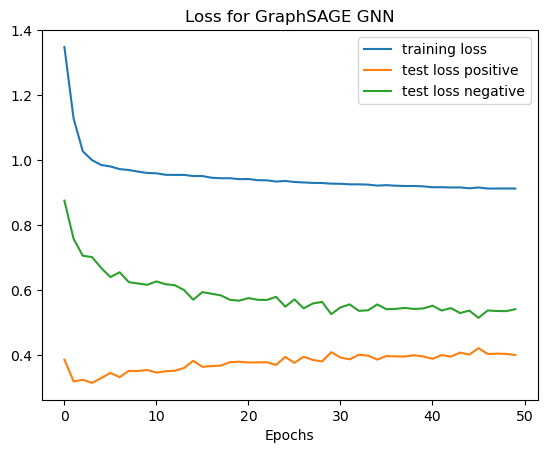

In [23]:
plt.title('Loss for GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
# plt.plot(loss_val_pos_list,label="validation loss positive")
# plt.plot(loss_val_neg_list,label="validation loss negative")
plt.plot(loss_test_pos_list,label="test loss positive")
plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()

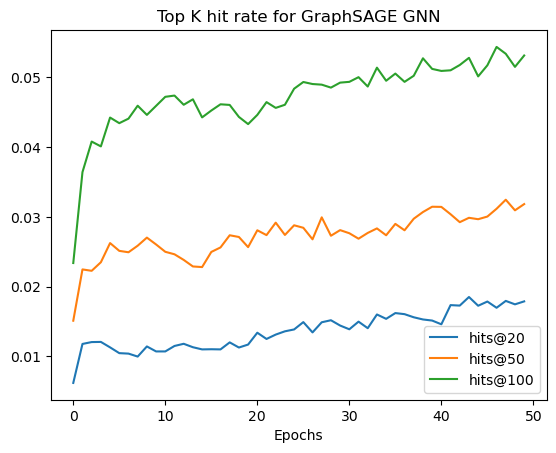

In [36]:
plt.title('Top K hit rate for GraphSAGE GNN')
plt.plot([a for a, b in hits_20],label="hits@20")
plt.plot([a for a, b in hits_50],label="hits@50")
plt.plot([a for a, b in hits_100],label="hits@100")
plt.xlabel('Epochs')
plt.legend()
plt.show()

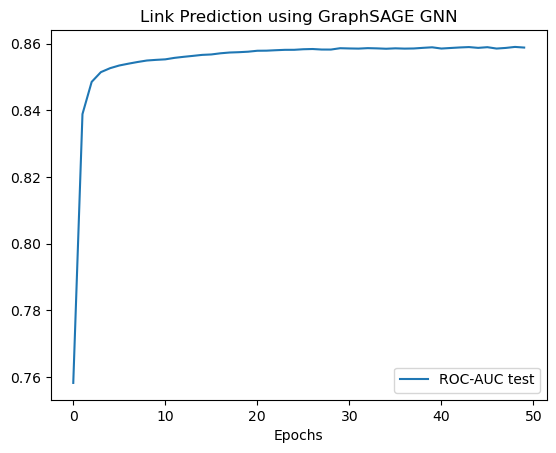

In [38]:
plt.title('Link Prediction using GraphSAGE GNN')
# plt.plot(roc_auc_val,label="ROC-AUC validation")
plt.plot(roc_auc_test,label="ROC-AUC test")
plt.xlabel('Epochs')
plt.legend()
plt.show()